In [1]:
import torch, torchvision
from torch import nn
from torch import optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.transforms import ToTensor
from torchvision.transforms import AutoAugment
from torchvision.transforms.autoaugment import AutoAugmentPolicy
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import requests
from PIL import Image
from io import BytesIO

import copy

from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

batch_size = 128

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

device(type='cuda', index=0)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_aug = transforms.Compose([ transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),     
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), 
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
                                      AutoAugment( policy = AutoAugmentPolicy.CIFAR10),
                                      transforms.ToTensor(), 
                                        ])

root ='./'
trainset = torchvision.datasets.CIFAR10( root , train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10( root , train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

trainset_augm = torchvision.datasets.CIFAR10( root , train=True,
                                        download=True, transform=transform_aug)

trainloader_augm = torch.utils.data.DataLoader(trainset_augm, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified
Files already downloaded and verified


In [4]:
model = models.resnet18(pretrained=False)

model.conv1 = nn.Conv2d( 3, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model_augm = copy.deepcopy(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total


def train(model, trainloader, testloader, numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = model.to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, testloader))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
        #print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    return best_model, accuracies

In [6]:
train_model , accuracies = train( model, trainloader, testloader, 70  , device=device)

In [7]:
train_model_augm , accuracies_augm = train( model_augm , trainloader_augm, testloader, 70  , device=device)

In [8]:
print( f'accuracy without aug={np.max(accuracies)} ; with aug ={np.max(accuracies_augm)} ' )

accuracy without aug=77.0999984741211 ; with aug =82.52999877929688 


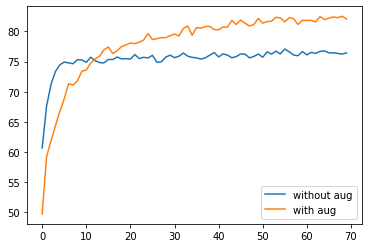

In [10]:
x_shape = [ i for i in range(70)]

plt.plot( x_shape, accuracies, label='without aug')
plt.plot( x_shape, accuracies_augm, label='with aug')
plt.legend()
plt.show()